In [1]:
# !pip install lifetimes
# !pip install sqlalchemy

In [2]:
import datetime as dt

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sqlalchemy import create_engine
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import summary_data_from_transaction_data

In [3]:
# order_items = pd.read_parquet('/content/drive/MyDrive/order_items_optimized.parquet')
order_items = pd.read_parquet('../../dataset/Looker Ecommerce BigQuery Dataset/Optimization/order_items_optimized.parquet')

In [4]:
# 구매건만 남기기
# order_items_extracted = order_items.query('status != "Returned" and status != "Cancelled"')
order_items_extracted = order_items[(order_items['status']!="Returned") & (order_items['status'] != "Cancelled")]


In [5]:
# # 'created_at' 열을 datetime 형식으로 변환
# order_items_extracted['created_at'] = pd.to_datetime(order_items_extracted['created_at'])

# # UTC에서 로컬 시간으로 변환
# order_items_extracted['created_at'] = order_items_extracted['created_at'].dt.tz_localize(None)

# # 'created_at' 열의 데이터 타입 확인
# print(order_items_extracted['created_at'].dtype)

# "2023-12-01" 이전의 행만 선택
# order_items_extracted = order_items_extracted.query('created_at < "2023-12-01"')
order_items_extracted = order_items_extracted[order_items_extracted['created_at']<"2023-12-01"]

In [6]:
# Recency 계산 (데이터 제일 최근 날짜 + 1일 기준)
recency = order_items_extracted .groupby('user_id')['created_at'].max().reset_index()
recency = recency.assign(recency = (order_items_extracted['created_at'].max() - recency['created_at'] + pd.to_timedelta(1, unit='d')).dt.days)
# 두번째 줄은 가독성상 별로 안좋은 것 같기는 함(여러줄로 분할하는 것 고려)

In [7]:
# Frequency 계산
frequency = order_items_extracted.groupby('user_id')['order_id'].nunique().reset_index()
frequency = frequency.rename(columns={'order_id': 'frequency'}) # 컬럼명 변경

In [8]:
# Monetary 계산
monetary = order_items_extracted.groupby('user_id')['sale_price'].sum().reset_index()

In [9]:
# RFM 데이터프레임 생성
rfm = recency[['user_id', 'recency']].merge(frequency, on='user_id')
rfm = rfm.merge(monetary, on='user_id')
rfm= rfm.rename(columns={'sale_price' : 'monetary'})
rfm['monetary'] = rfm['monetary'] / rfm['frequency'] # monetary 총매출이 아닌 평균으로 바꾸기
rfm


,user_id,recency,frequency,monetary
0,1,499,1,159.990000
1,2,649,1,22.000000
2,3,115,4,100.550000
3,4,409,1,148.000000
4,6,599,1,144.820004
...,...,...,...,...
58459,99989,91,1,15.120000
58460,99992,479,1,55.950001
58461,99996,261,2,61.935000
58462,99998,132,3,38.996667


In [10]:
from sklearn.cluster import KMeans

In [11]:
# 모델 초기화
kmeans_RFM = KMeans(n_clusters=3, random_state=42)

# RFM 데이터를 사용하여 모델 학습
kmeans_RFM.fit(rfm[['recency', 'frequency', 'monetary']])

# 클러스터링 결과 확인
rfm = rfm.assign(cluster_RFM = kmeans_RFM.labels_)

# 결과 출력
display(rfm)

,user_id,recency,frequency,monetary,cluster_RFM
0,1,499,1,159.990000,0
1,2,649,1,22.000000,0
2,3,115,4,100.550000,1
3,4,409,1,148.000000,0
4,6,599,1,144.820004,0
...,...,...,...,...,...
58459,99989,91,1,15.120000,1
58460,99992,479,1,55.950001,0
58461,99996,261,2,61.935000,1
58462,99998,132,3,38.996667,1


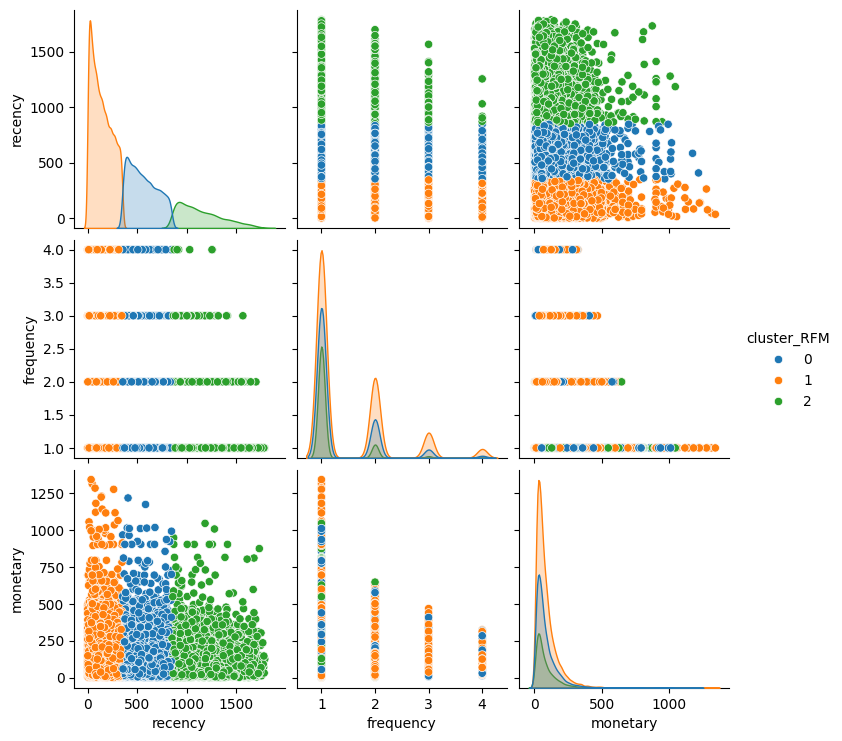

In [12]:
features = ['recency', 'frequency', 'monetary']

# 클러스터링 결과를 hue로 지정하여 시각화
sns.pairplot(rfm, vars=features, hue='cluster_RFM', palette='tab10', diag_kind='kde')

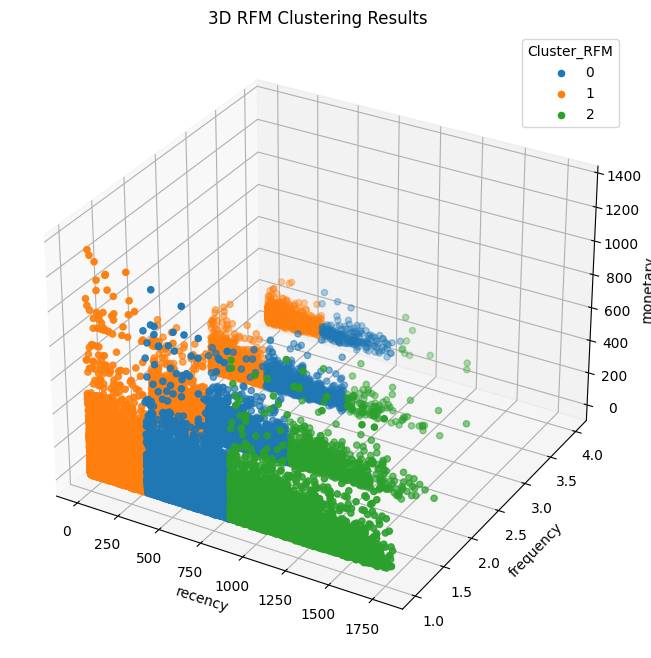

In [13]:
x_feature = 'recency'
y_feature = 'frequency'
z_feature = 'monetary'

# 클러스터링 결과를 색상으로 구분하여 3D 산점도 그리기
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label, cluster in rfm.groupby('cluster_RFM'):
    ax.scatter(cluster[x_feature], cluster[y_feature], cluster[z_feature], label=label)

ax.set_xlabel(x_feature)
ax.set_ylabel(y_feature)
ax.set_zlabel(z_feature)
ax.set_title('3D RFM Clustering Results')
ax.legend(title='Cluster_RFM')

In [14]:
#from sklearn.metrics import silhouette_score

# 실루엣 점수 계산
#silhouette_avg = silhouette_score(rfm_data, rfm_data['cluster'])

# 실루엣 점수 출력
#print(f'Silhouette Score: {silhouette_avg}')

In [15]:
print(rfm.columns)

Index(['user_id', 'recency', 'frequency', 'monetary', 'cluster_RFM'], dtype='object')


In [16]:
import numpy as np

# 이부분 상의 앞에 RFM한 부분만 따로 보관해둘지?

# GKSMS QJQ 방법론을 이용하여 각 고객의 CLV 계산
rfm = rfm.assign(G=rfm['monetary'])  # 과거 고객 가치 (Monetary를 사용)
# rfm_data = rfm[['user_id', 'monetary']].copy().rename(columns={'monetary': 'G'})  # 과거 고객 가치 (Monetary를 사용)
rfm = rfm.assign(K=rfm['monetary'] * rfm['frequency'])  # 현재 고객 가치
rfm = rfm.assign(S=rfm['monetary'] * rfm['frequency'] / rfm['recency'])  # 잔존 고객 가치
rfm = rfm.assign(M=np.log(rfm['frequency']) * rfm['monetary'])  # 모멘텀 고객 가치
# rfm = rfm.assign(S=rfm['monetary'] * rfm['frequency'] / rfm['recency'])  # 소셜 고객 가치
rfm = rfm.assign(Q=rfm['monetary'] / rfm['frequency'])  # 품질 고객 가치
rfm = rfm.assign(J=rfm['monetary'] * np.log(rfm['recency']))  # 행동 고객 가치


In [17]:
rfm = rfm.assign(CLV = rfm[['G', 'K', 'S', 'M', 'Q', 'J']].sum(axis=1))
rfm

,user_id,recency,frequency,monetary,cluster_RFM,G,K,S,M,Q,J,CLV
0,1,499,1,159.990000,0,159.990000,159.990000,0.320621,0.000000,159.990000,993.954848,1474.245468
1,2,649,1,22.000000,0,22.000000,22.000000,0.033898,0.000000,22.000000,142.459520,208.493418
2,3,115,4,100.550000,1,100.550000,402.200001,3.497391,139.391898,25.137500,477.102926,1147.879717
3,4,409,1,148.000000,0,148.000000,148.000000,0.361858,0.000000,148.000000,890.029843,1334.391701
4,6,599,1,144.820004,0,144.820004,144.820004,0.241770,0.000000,144.820004,926.161807,1360.863587
...,...,...,...,...,...,...,...,...,...,...,...,...
58459,99989,91,1,15.120000,1,15.120000,15.120000,0.166154,0.000000,15.120000,68.204196,113.730351
58460,99992,479,1,55.950001,0,55.950001,55.950001,0.116806,0.000000,55.950001,345.306653,513.273461
58461,99996,261,2,61.935000,1,61.935000,123.870001,0.474598,42.930071,30.967500,344.638574,604.815744
58462,99998,132,3,38.996667,1,38.996667,116.990000,0.886288,42.842217,12.998889,190.412999,403.127059


In [18]:
# Selecting relevant columns for clustering
X = rfm[['G', 'K', 'S', 'M', 'Q', 'J']]

# Number of clusters you want
num_clusters = 5  # You can adjust this based on your data and requirements

# Perform K-means clustering
kmeans_GKSMQJ = KMeans(n_clusters=num_clusters, random_state=42) #모델 이미 학습되어있는 것 그대로 새로 학습, 의도하신건지?
kmeans_GKSMQJ.fit(X)

# Adding cluster labels to the DataFrame
rfm['cluster_CLV'] = kmeans_GKSMQJ.labels_ # 이전 해둔것 덮어쓰기로 하게 되어있는데 의도하신건지?

# Viewing the clusters
cluster_centers = pd.DataFrame(kmeans_GKSMQJ.cluster_centers_, columns=['G', 'K', 'S', 'M', 'Q', 'J'])
display(cluster_centers)

# Checking the count of data points in each cluster
print(rfm['cluster_CLV'].value_counts())

,G,K,S,M,Q,J
0,102.632210,156.888382,1.940102,32.904621,80.780075,552.785706
1,193.987935,253.306190,1.656604,37.510516,168.412991,1115.332835
2,39.415995,55.797549,2.693804,10.088788,32.651788,192.283035
3,806.098364,828.161173,3.460029,15.292774,795.066960,4820.211069
4,356.013668,411.624765,1.818341,36.166124,330.899557,2134.432283


cluster_CLV
2    33422
0    16486
1     6757
4     1637
3      162
Name: count, dtype: int64


In [19]:
rfm

,user_id,recency,frequency,monetary,cluster_RFM,G,K,S,M,Q,J,CLV,cluster_CLV
0,1,499,1,159.990000,0,159.990000,159.990000,0.320621,0.000000,159.990000,993.954848,1474.245468,1
1,2,649,1,22.000000,0,22.000000,22.000000,0.033898,0.000000,22.000000,142.459520,208.493418,2
2,3,115,4,100.550000,1,100.550000,402.200001,3.497391,139.391898,25.137500,477.102926,1147.879717,0
3,4,409,1,148.000000,0,148.000000,148.000000,0.361858,0.000000,148.000000,890.029843,1334.391701,1
4,6,599,1,144.820004,0,144.820004,144.820004,0.241770,0.000000,144.820004,926.161807,1360.863587,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58459,99989,91,1,15.120000,1,15.120000,15.120000,0.166154,0.000000,15.120000,68.204196,113.730351,2
58460,99992,479,1,55.950001,0,55.950001,55.950001,0.116806,0.000000,55.950001,345.306653,513.273461,2
58461,99996,261,2,61.935000,1,61.935000,123.870001,0.474598,42.930071,30.967500,344.638574,604.815744,2
58462,99998,132,3,38.996667,1,38.996667,116.990000,0.886288,42.842217,12.998889,190.412999,403.127059,2


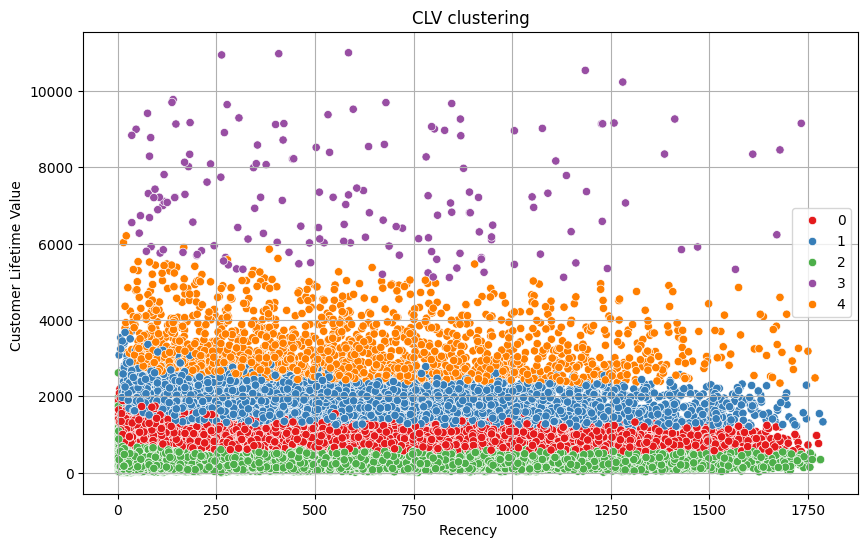

In [20]:
# 산점도 그리기
plt.figure(figsize=(10, 6))

# 각 클러스터에 대한 산점도
sns.scatterplot(x='recency', y='CLV', hue='cluster_CLV', data=rfm, palette='Set1')


# 라벨과 제목 추가
plt.xlabel('Recency ')
plt.ylabel('Customer Lifetime Value ')
plt.title('CLV clustering')
plt.legend()
plt.grid(True)
plt.show()

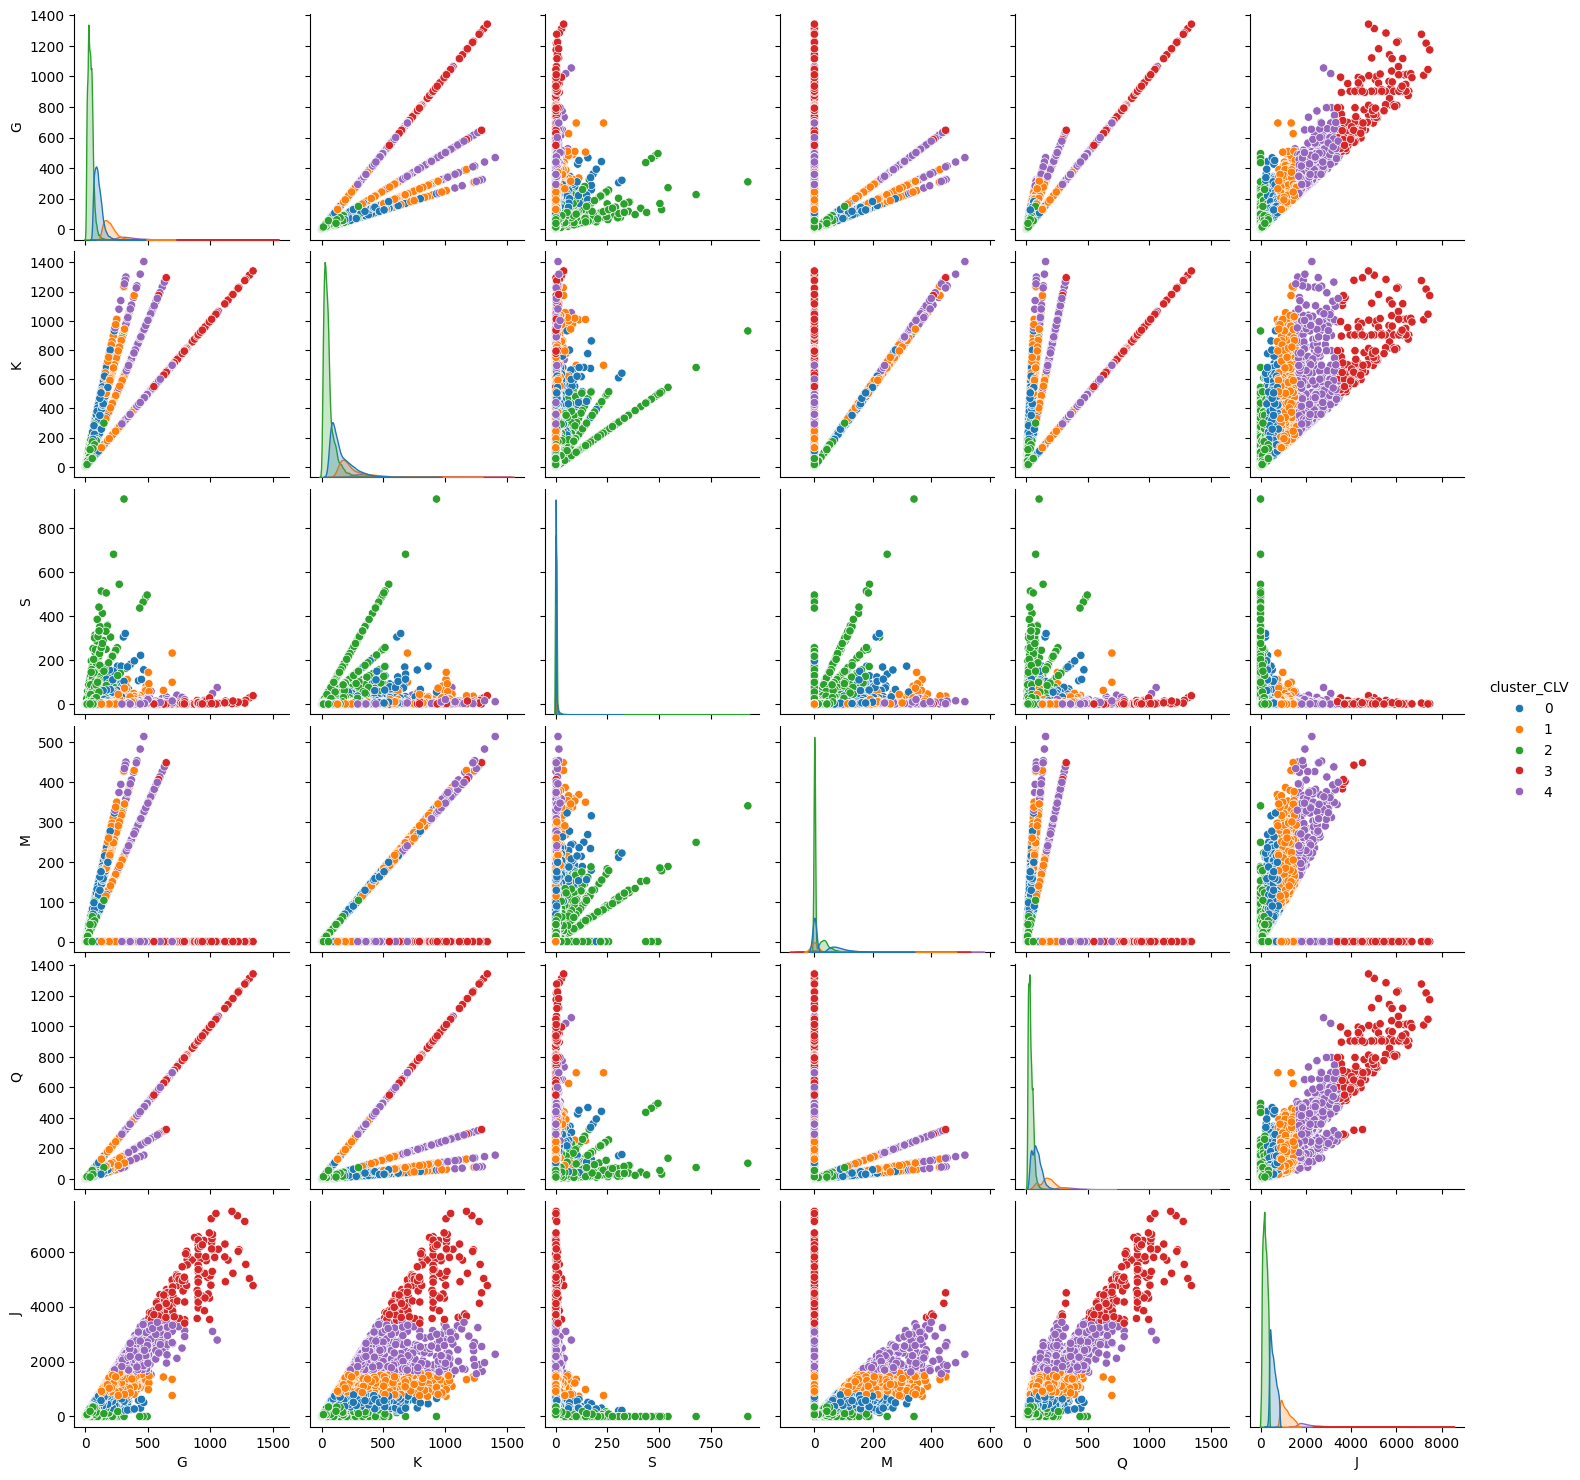

In [21]:
features = ['G', 'K', 'S', 'M', 'Q', 'J']
# 클러스터링 결과를 hue로 지정하여 시각화
sns.pairplot(rfm, vars=features, hue='cluster_CLV', palette='tab10', diag_kind='kde')

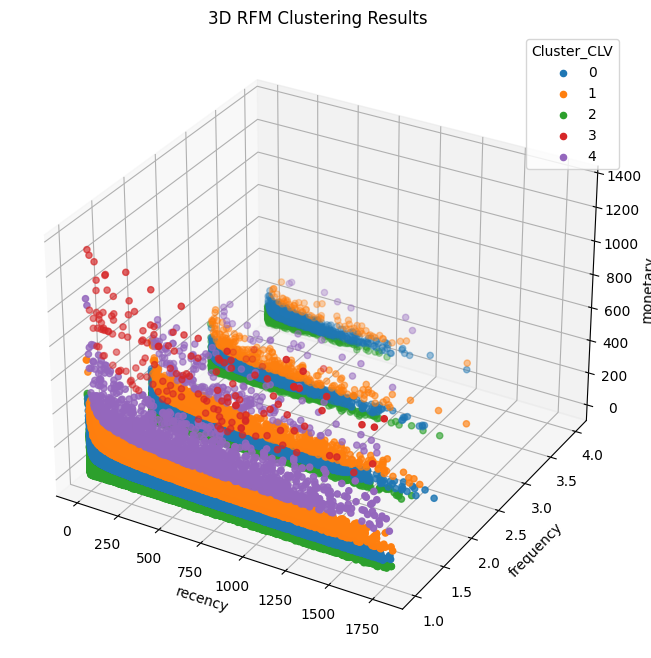

In [22]:
x_feature = 'recency'
y_feature = 'frequency'
z_feature = 'monetary'

# 클러스터링 결과를 색상으로 구분하여 3D 산점도 그리기
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label, cluster in rfm.groupby('cluster_CLV'):
    ax.scatter(cluster[x_feature], cluster[y_feature], cluster[z_feature], label=label)

ax.set_xlabel(x_feature)
ax.set_ylabel(y_feature)
ax.set_zlabel(z_feature)
ax.set_title('3D RFM Clustering Results')
ax.legend(title='Cluster_CLV')

In [24]:
rfm.to_csv('../../dataset/Looker Ecommerce BigQuery Dataset/result/RFM_CLV_Cluster.csv', index=False)